In [114]:
from pathlib import Path

ANNOTATIONS_BASE_PATH = "/kaggle/input/vizwiz/Annotations/Annotations/"
IMAGES_TRAIN_PATH = "/kaggle/input/vizwiz/train/train/"
IMAGES_TEST_PATH = "/kaggle/input/vizwiz/test/test/"
IMAGES_VAL_PATH = "/kaggle/input/vizwiz/val/val/"
ANSWER_SPACE_EMBED_PATH = "/kaggle/input/answer-space-embed/answer_embed.pt"
ANNOTATIONS_TRAIN_PATH = str(Path(ANNOTATIONS_BASE_PATH)/"train.json")
ANNOTATIONS_VAL_PATH = str(Path(ANNOTATIONS_BASE_PATH)/"val.json")

ANSWER_SPACE_SIZE = 3000

In [115]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import matplotlib.image as mpimg
import pandas as pd
from transformers import AutoTokenizer, AutoFeatureExtractor, AutoModel, TrainingArguments, Trainer, logging
from sklearn.metrics import accuracy_score, f1_score
import wandb
import json
import datetime
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [116]:
os.environ['HF_HOME'] = os.path.join(".", "cache")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_caching_enabled(True)
logging.set_verbosity_error()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [117]:
def plot_histogram(dataframe, column):
    plt.hist(dataframe[column])
    plt.title(column)
    plt.show()

def plot_pie(dataframe, column):
    value_counts = dataframe[column].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    plt.title(column)
    plt.show()

def plot_wordcloud(dataframe, column):
    text = " ".join([word for word in dataframe[column]])

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10).generate(text) 
    
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

def explore_dataframe(dataframe):
    plot_pie(dataframe, 'answer_type')
    plot_pie(dataframe, 'answerable')
    plot_wordcloud(dataframe, 'question')

def get_number_of_distinct_answers(dataframe):
    unique_answers_set = set()
    for row in dataframe['answers']:
        for answer_map in row:
            unique_answers_set.add(answer_map['answer'])
    return len(unique_answers_set)


In [118]:
train_df_EDA = pd.read_json(ANNOTATIONS_TRAIN_PATH)
train_df_EDA

,image,question,answers,answer_type,answerable
0,VizWiz_train_00000000.jpg,What's the name of this product?,"[{'answer_confidence': 'yes', 'answer': 'basil...",other,1
1,VizWiz_train_00000001.jpg,Can you tell me what is in this can please?,"[{'answer_confidence': 'yes', 'answer': 'soda'...",other,1
2,VizWiz_train_00000002.jpg,Is this enchilada sauce or is this tomatoes? ...,"[{'answer_confidence': 'yes', 'answer': 'these...",other,1
3,VizWiz_train_00000003.jpg,What is the captcha on this screenshot?,"[{'answer_confidence': 'yes', 'answer': 't36m'...",other,1
4,VizWiz_train_00000004.jpg,What is this item?,"[{'answer_confidence': 'yes', 'answer': 'solar...",other,1
...,...,...,...,...,...
20518,VizWiz_train_00023949.jpg,What's the color for this laptop?,"[{'answer': 'grey black', 'answer_confidence':...",other,1
20519,VizWiz_train_00023950.jpg,"(inaudible) can you see it? If so, then tell m...","[{'answer': 'yes', 'answer_confidence': 'maybe...",other,1
20520,VizWiz_train_00023951.jpg,What are the three numbers I have to type?,"[{'answer': '321', 'answer_confidence': 'no'},...",unanswerable,0
20521,VizWiz_train_00023952.jpg,Is it a box?,"[{'answer': 'no', 'answer_confidence': 'yes'},...",yes/no,1


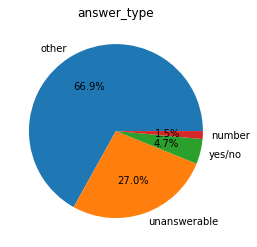

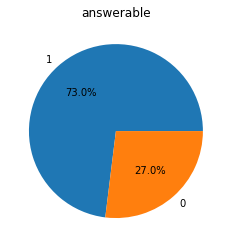

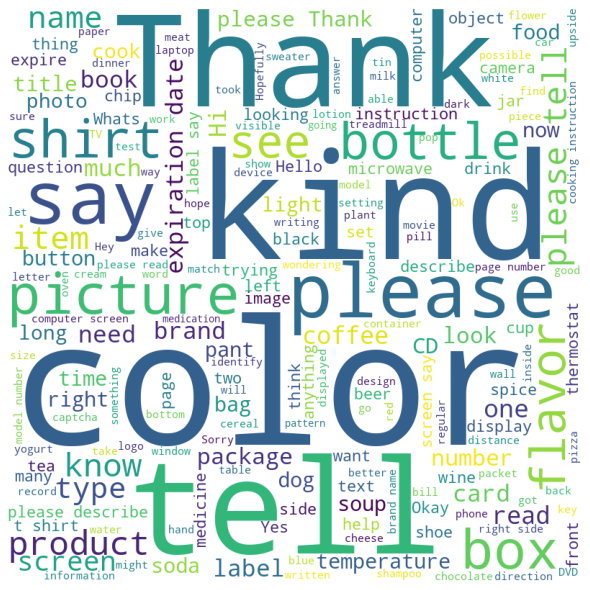

Number of distinct answers:  41229
Number of samples in train:  20523


In [119]:
explore_dataframe(train_df_EDA)
print("Number of distinct answers: ", get_number_of_distinct_answers(train_df_EDA))
print("Number of samples in train: ", len(train_df_EDA))

In [120]:
train_df_EDA['comb_answers'] = train_df_EDA['answers'].map(lambda x: ' '.join(set([r['answer'].lower().strip() for r in x])))

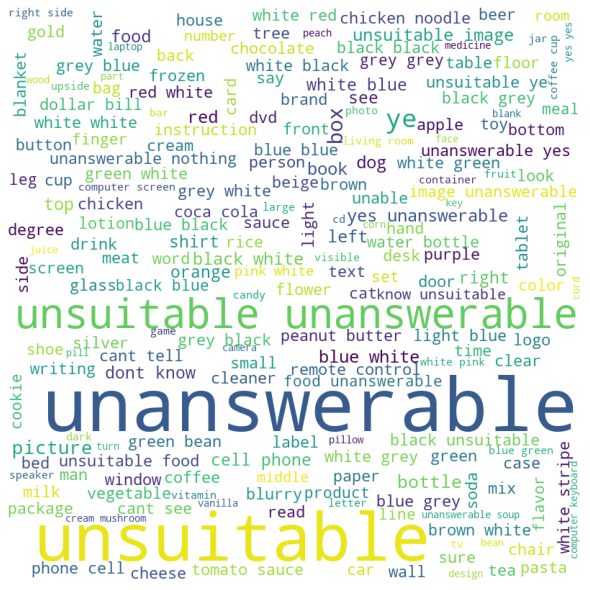

In [121]:
plot_wordcloud(train_df_EDA, 'comb_answers')

In [122]:
train_df_EDA[train_df_EDA['comb_answers'].str.startswith("unsuitable")]

,image,question,answers,answer_type,answerable,comb_answers
11,VizWiz_train_00000011.jpg,What is the sodium content of this can of food?,"[{'answer_confidence': 'no', 'answer': 'unansw...",unanswerable,0,unsuitable unanswerable insufficient photo qua...
21,VizWiz_train_00000021.jpg,"Alright, and what does this label say?","[{'answer_confidence': 'yes', 'answer': 'unsui...",unanswerable,0,unsuitable
26,VizWiz_train_00000026.jpg,What is this?,"[{'answer_confidence': 'yes', 'answer': 'unsui...",other,1,unsuitable sleep lotion sleep lotion
27,VizWiz_train_00000027.jpg,Am I right when I say that this string is blank?,"[{'answer_confidence': 'yes', 'answer': 'unsui...",unanswerable,0,unsuitable yes unanswerable
28,VizWiz_train_00000028.jpg,What can is this?,"[{'answer_confidence': 'yes', 'answer': 'unans...",unanswerable,0,unsuitable unanswerable tuna
...,...,...,...,...,...,...
20512,VizWiz_train_00023943.jpg,What bus number is on this map?,"[{'answer': '11 805', 'answer_confidence': 'ma...",other,1,unsuitable image 805 11 11 805 11 805
20514,VizWiz_train_00023945.jpg,"Hi, can you please tell me the numbers that ar...","[{'answer': 'unsuitable image', 'answer_confid...",unanswerable,0,unsuitable image no numbers listed unanswerable
20515,VizWiz_train_00023946.jpg,Can you tell me what this says on this box?,"[{'answer': 'unanswerable', 'answer_confidence...",unanswerable,0,unsuitable image unanswerable
20518,VizWiz_train_00023949.jpg,What's the color for this laptop?,"[{'answer': 'grey black', 'answer_confidence':...",other,1,unsuitable image metallic grey black silver gr...


In [123]:
train_df_EDA['comb_answers'].str.startswith("unsuitable").mean()

0.1907615845636603

In [124]:
train_df_EDA['comb_answers'].str.startswith("unsuitable image").mean()

0.011840374214296156

In [125]:
class VQAData:
    def __init__(self, annotation_fp, image_base_path):
        self.df = pd.read_json(annotation_fp,orient="records")
        def most_common(lst):
            data = Counter(lst)
            return max(lst, key=data.get)
        
        self.df["max_answer"] = self.df["answers"].apply(lambda row:most_common([ans["answer"] for ans in row]))
        self.df["max_answer_confidence"] = self.df["answers"].apply(lambda row:most_common([ans["answer_confidence"] for ans in row]))
        self.df["answer_list"] = self.df["answers"].apply(lambda row:[ans["answer"] for ans in row])
        image_base_path = Path(image_base_path)
        self.df["image_path"] = self.df["image"].apply(lambda row:str(image_base_path/row))
        
    def get_df(self,fields=["image_path","question","max_answer"], answer_type=None):
        if(answer_type!=None):
            _df = self.df[self.df["answer_type"]==answer_type].reset_index(drop=True)
        else:
            _df = self.df.copy()
        return(_df[fields])

In [126]:
vqa_train = VQAData(ANNOTATIONS_TRAIN_PATH,IMAGES_TRAIN_PATH)
vqa_val = VQAData(ANNOTATIONS_VAL_PATH,IMAGES_VAL_PATH)
train_df = vqa_train.get_df(fields=["image_path","question","max_answer","answer_list"])
val_df = vqa_val.get_df(fields=["image_path","question","max_answer","answer_list"])

In [128]:
def clean_answer(word):
    if word == "unsuitable image":
        return "unsuitable"
    else:
        return word
train_df["answer_list"] = train_df["answer_list"].apply(lambda ans:[clean_answer(w) for w in ans])
val_df["answer_list"] = val_df["answer_list"].apply(lambda ans:[clean_answer(w) for w in ans])

In [96]:
total_answer_counts = train_df["answer_list"].append(val_df["answer_list"]).explode().value_counts()
answer_space = total_answer_counts.head(ANSWER_SPACE_SIZE).index.to_list()
answer_space.append("<Unknown>")

In [130]:
print(total_answer_counts)

unanswerable                                        36989
unsuitable                                          32688
no                                                   6565
yes                                                  5488
white                                                3003
                                                    ...  
transparent                                             1
displays military time                                  1
fm radio station bbc r4 16:07 11 degrees celcius        1
radio time                                              1
garam marsala                                           1
Name: answer_list, Length: 48729, dtype: int64


In [139]:
word_coutns = train_df["answer_list"].append(val_df["answer_list"]).explode().str.split(expand=True).stack().value_counts(1)
word_coutns

unanswerable    0.089536
unsuitable      0.079101
no              0.019455
white           0.016485
yes             0.015000
                  ...   
disbelief       0.000002
suspend         0.000002
endiciacom      0.000002
catchup         0.000002
trade           0.000002
Length: 17395, dtype: float64

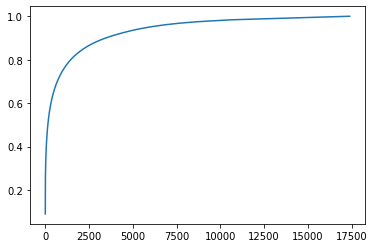

In [140]:
plt.plot(range(len(word_coutns)), word_coutns.cumsum());

In [97]:
from collections import Counter
def choose_ans_label(ans_list):
    ans_dict = Counter(ans_list)
    max_entry = "<Unknown>"
    max_count = 0
    for k,v in ans_dict.items():
        if k in answer_space and v>max_count:
            max_count = v
            max_entry = k
    return max_entry

In [98]:
train_df["selected_answer"] = train_df["answer_list"].apply(lambda row:choose_ans_label(row))
val_df["selected_answer"] = val_df["answer_list"].apply(lambda row:choose_ans_label(row))

In [10]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories = [answer_space[:-1]],handle_unknown="use_encoded_value",unknown_value=ANSWER_SPACE_SIZE)
enc.fit(train_df["selected_answer"].values.reshape(-1,1))
train_df["labels"] = enc.transform(train_df["selected_answer"].values.reshape(-1,1)).astype(int)
val_df["labels"] = enc.transform(val_df["selected_answer"].values.reshape(-1,1)).astype(int)
train_df = train_df[train_df["labels"]!=ANSWER_SPACE_SIZE]
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
train_df["id"] = train_df.index
val_df["id"] = val_df.index

In [11]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [12]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=68,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(image_path).convert('RGB') for image_path in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }
            
    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_path']
                if isinstance(raw_batch_dict, dict) else
                [i['image_path'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                [raw_batch_dict['labels'],raw_batch_dict["id"]]
                if isinstance(raw_batch_dict, dict) else
                [[i['labels'],i['id']] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

In [13]:
# Based on https://github.com/AdeelH/pytorch-multi-class-focal-loss/blob/master/focal_loss.py

from typing import Optional, Sequence

import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F

class FocalLoss(nn.Module):
    """ Focal Loss, as described in https://arxiv.org/abs/1708.02002.
    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(self,
                 alpha: Optional[Tensor] = None,
                 gamma: float = 0.,
                 reduction: str = 'mean',
                 label_smoothing: float = 0.0,
                 ignore_index: int = -100):
        """Constructor.
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(
                'Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction
        self.label_smoothing = label_smoothing

        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)

    def __repr__(self):
        arg_keys = ['alpha', 'gamma', 'ignore_index', 'reduction']
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f'{k}={v}' for k, v in zip(arg_keys, arg_vals)]
        arg_str = ', '.join(arg_strs)
        return f'{type(self).__name__}({arg_str})'

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return torch.tensor(0.)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        
        if self.label_smoothing==0:
            ce = self.nll_loss(log_p, y)
        else:
            ce = (1 - self.label_smoothing)*self.nll_loss(log_p, y) - self.label_smoothing * log_p.mean(dim=-1)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss

In [14]:
total_answer_counts = train_df["answer_list"].append(val_df["answer_list"]).explode().value_counts()
total_answer_counts = total_answer_counts[total_answer_counts.index.isin(answer_space)][answer_space[:-1]]

freq_weight = 1/np.log(total_answer_counts.head(ANSWER_SPACE_SIZE).values+10)
freq_weight = torch.tensor(np.append(freq_weight/np.mean(freq_weight),[0]),dtype=torch.float)

focal_loss = FocalLoss(
        alpha=freq_weight,
        gamma=2,
        reduction='mean',
        label_smoothing=0.0)

print(freq_weight)

tensor([0.3123, 0.3160, 0.3737,  ..., 1.1365, 1.1365, 0.0000])


In [15]:
# https://github.com/jiasenlu/vilbert_beta/blob/master/vilbert/basebert.py
from torch.nn.utils.weight_norm import weight_norm

class MultimodalVQAModel(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'bert-base-uncased',
            pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'):
     
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        
        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )
        
        hidden_size = self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size
        intermediate_dim = hidden_size*2
        self.fusion = nn.Sequential(
            nn.Dropout(0.1),
            weight_norm(nn.Linear(hidden_size, intermediate_dim)),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        
        for m in self.fusion:
            if isinstance(m, nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight)
                torch.nn.init.normal_(m.bias,std=0.03)
        
        try:
            for m in self.classifier:
                if isinstance(m, nn.Linear):
                    torch.nn.init.kaiming_normal_(m.weight)
                    torch.nn.init.normal_(m.bias,std=0.03)
        except:
            torch.nn.init.kaiming_normal_(self.classifier.weight)
            torch.nn.init.normal_(self.classifier.bias,std=0.03)
        
        
        self.criterion = focal_loss
    
    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):
        
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)
        
        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels[:,0])
            out["loss"] = loss
        
        return out

In [16]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)

    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )
    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

In [17]:
def vqa_accuracy_score(val_id, preds):
    acc_sum = 0
    for v_id, pred in zip(val_id,preds):
        pred_word = answer_space[pred]
        answer_list = val_df.at[v_id,'answer_list']
        acc_sum+=min(answer_list.count(pred_word)/3,1)
    return acc_sum/len(preds)

def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        "acc": accuracy_score(labels[:,0], preds),
        "vqa_acc": vqa_accuracy_score(labels[:,1], preds),
        "f1": f1_score(labels[:,0], preds, average='macro')
    }

In [18]:
args = TrainingArguments(
    output_dir="answer_embed_into_model",
    seed=2022, 
    evaluation_strategy="steps",
    eval_steps=620,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=620,
    save_total_limit=1,              
    metric_for_best_model='vqa_acc',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    num_train_epochs=20,
    fp16=True,
    dataloader_pin_memory=False,
    log_level="warning",
    warmup_ratio=0.06,
    learning_rate=1e-5,
    weight_decay=0.1,
    dataloader_num_workers=2,
    load_best_model_at_end=True,
)

In [19]:
def createAndTrainModel(dataset, args, text_model='bert-base-uncased', image_model='google/vit-base-patch16-224-in21k', multimodal_model='bert_vit'):
    collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)
    
    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join(".", "checkpoint", multimodal_model)
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['val'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )
    
    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()
    test_results = multi_trainer.predict(dataset['val'])
    
    return collator, model, train_multi_metrics, eval_multi_metrics, test_results

In [20]:
%env WANDB_PROJECT=vizwiz_results
%env WANDB_WATCH=all

env: WANDB_PROJECT=vizwiz_results
env: WANDB_WATCH=all


In [ ]:
wandb.init(name = "Basic model", notes="Basic model. dropout(0.1) lr(1e-5)", save_code=True, reinit=True)

In [ ]:
collator, model, train_multi_metrics, eval_multi_metrics, test_results = createAndTrainModel({"train": train_dataset,"val": val_dataset}, args,
                                                                              text_model='roberta-base', image_model="microsoft/beit-base-patch16-224-pt22k-ft22k")

In [ ]:
val_df["prediction_label"] = test_results.predictions.argmax(1)
val_df["answer"] = val_df["prediction_label"].apply(lambda i: answer_space[i])
val_df["image"] = val_df["image_path"].apply(lambda x:x.split("/")[-1])
val_df[["image","answer"]].to_json("./val_real_results.json",orient = "records")

# Saving predictions to wandb
wandb.save('./val_real_results.json', policy="now")
wandb.finish()

In [26]:
latest_checkpoint_path = '/kaggle/input/ptmodel/pytorch_model.bin'
text_model='roberta-base'
image_model="microsoft/beit-base-patch16-224-pt22k-ft22k"

collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)
model.load_state_dict(torch.load(latest_checkpoint_path))
model.to(device) 

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/276 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/395M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


MultimodalVQAModel(
  (text_encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Lay

In [28]:
val_dataset

Dataset({
    features: ['image_path', 'question', 'max_answer', 'answer_list', 'selected_answer', 'labels', 'id'],
    num_rows: 4319
})

In [82]:
import random
random.seed(1)

random_sample_indices = random.sample(range(100), k=10)
sample = collator([val_dataset[index] for index in random_sample_indices])
input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

In [83]:
model.eval()
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

In [84]:
predictions = output["logits"].argmax(axis=-1).cpu().numpy()

In [90]:
predictions_str = enc.inverse_transform(predictions.reshape(-1, 1)).flatten()

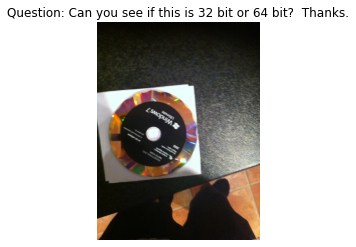

Actual Answer: unsuitable image
Predicted Answer: regular 



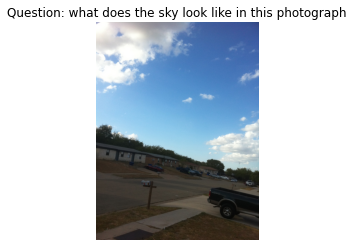

Actual Answer: clear
Predicted Answer: clear 



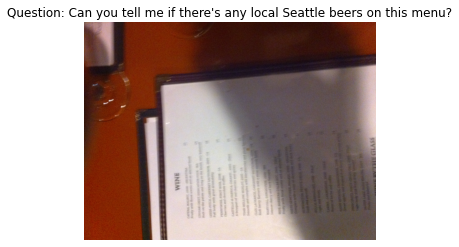

Actual Answer: unsuitable image
Predicted Answer: unsuitable 



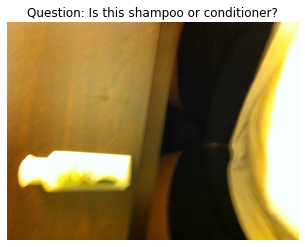

Actual Answer: unsuitable image
Predicted Answer: unsuitable 



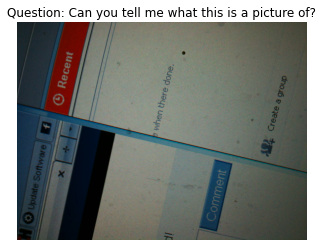

Actual Answer: computer screen
Predicted Answer: unsuitable 



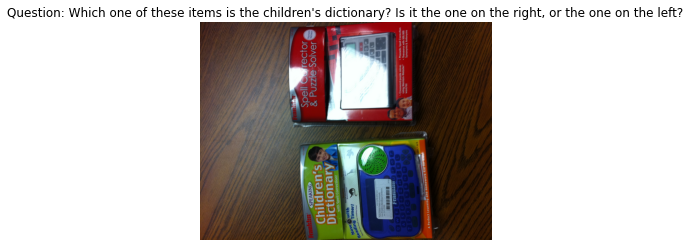

Actual Answer: left
Predicted Answer: right 



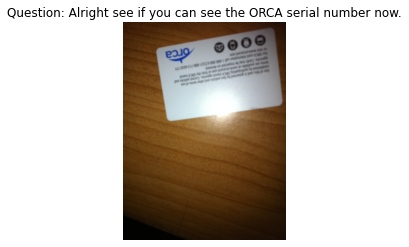

Actual Answer: no
Predicted Answer: no 



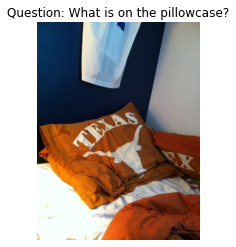

Actual Answer: texas
Predicted Answer: pillow 



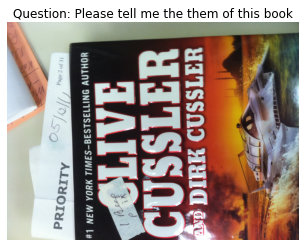

Actual Answer: clive cussler dirk cussler
Predicted Answer: unanswerable 



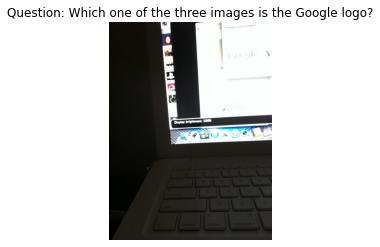

Actual Answer: unanswerable
Predicted Answer: unsuitable 



In [97]:
for i, sample_id in enumerate(random_sample_indices):
    plt.figure()
    image_path = val_dataset['image_path'][sample_id]
    image = mpimg.imread(image_path)
    plt.imshow(image)
    plt.title(f"Question: {val_dataset['question'][sample_id]}")
    plt.axis('off')  
    plt.show()
    print("Actual Answer:", val_dataset['max_answer'][sample_id])
    print("Predicted Answer:", predictions_str[i], "\n")